# Import packages

In [1]:
# loading packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
plt.rcParams['figure.dpi'] = 300

import matplotlib.dates as mdates

# ignoring warnings
import warnings
warnings.simplefilter("ignore")

In [2]:
import sklearn as sk
import statsmodels.api as sm

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.api import ARMA


from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson

from sklearn.metrics import r2_score,mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor

import copy

# Custom functions

In [3]:
def diff_for_stationarity(df_input,cols,threshold):
    
    """Checks the series for stationarity then difference it until it is stationary
    (with the given threshold)"""
    
    df = copy.deepcopy(df_input)
    
    
    # Get length of DF
    n = len(df)
    
    # Loop over columns of interest
    for col in cols:
        stationarity = False
        series = list(df[col].astype(float))
        linear_diff = False
        
        try:
        
            counter = 0



            while not stationarity:

                #print(counter)

                # Run ADF test
                adf_test = adfuller(series)
                pval = adf_test[1]

                if pval < threshold:
                    stationarity = True

                else:
                    # Difference the series
                    #series = [np.log(series[i]/series[i-1]) for i in range(1,n-counter)]
                    series = [series[i]-series[i-1] for i in range(1,n-counter)]

                    counter += 1
                    
        except:
            
            counter = 0
            stationarity = False
            series = list(df[col].astype(float))
            linear_diff = True

            while not stationarity:

                #print(counter)

                # Run ADF test
                adf_test = adfuller(series)
                pval = adf_test[1]

                if pval < threshold:
                    stationarity = True

                elif counter>1:
                    stationarity = True
                    series = list(df[col].astype(float))
                else:
                    # Difference the series
                    series = [series[i]-series[i-1] for i in range(1,n-counter)]

                    counter += 1
        
        # Create final series and assign it back to the dataframe
        final_series = [None]*counter + series
        df[col] = final_series
        
        if linear_diff:
            type_diff = "linear difference"
        else:
            type_diff = "linear difference"
        
        print("Variable: {} is {}-order integrated ({})!".format(col,counter,type_diff))
        
        
    return df

# Import data

In [4]:
df = pd.read_csv('../Data/daily_prices.csv')

df.set_index('Date',inplace=True)

print(df.head())

                  Price
Date                   
02/01/2017 00:00   6.12
03/01/2017 00:00   5.43
04/01/2017 00:00   5.72
05/01/2017 00:00   5.29
06/01/2017 00:00   5.50


# EDA

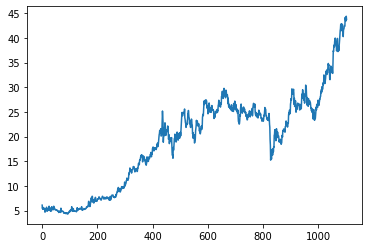

In [5]:
plt.plot(np.asarray(df.Price))
plt.show()

# Data preprocessing

## Handle missing values

In [6]:
df = df.fillna(method='bfill')

## Stationarity checks

In [7]:
# Parameters
stacioner_threshold = 0.01
arno_cols = df.columns
current_df = df

# Check for stationarity
df_stationer = diff_for_stationarity(df_input=current_df,cols=arno_cols,threshold=stacioner_threshold)

Variable: Price is 1-order integrated (linear difference)!


In [8]:
df_stationer

,Price
Date,
02/01/2017 00:00,NaN
03/01/2017 00:00,-0.69
04/01/2017 00:00,0.29
05/01/2017 00:00,-0.43
06/01/2017 00:00,0.21
...,...
07/04/2021 00:00,-0.38
08/04/2021 00:00,-0.38
09/04/2021 00:00,0.18


In [9]:
# Drop first row after differencing the series
df_stationer = df_stationer.dropna()

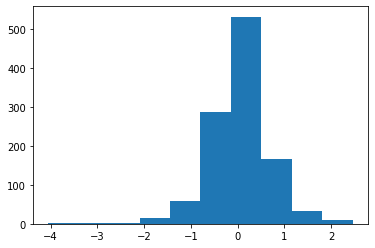

In [10]:
plt.hist(df_stationer.Price)
plt.show()

# Modelling

In [11]:
# Create train-test sets
n = len(df_stationer)
testsize = 0.2

test_obs = int(n*testsize)
df_train, df_test = df_stationer[0:-test_obs], df_stationer[-test_obs:]

# Check size
print(df_train.shape)
print(df_test.shape)

# Be careful with time leakage!

(883, 1)
(220, 1)


## ARMA(p,q)

In [12]:
# Fit the model
res = sm.tsa.arma_order_select_ic(df_train['Price'], ic=["aic", "bic","hqic"], trend="nc")

In [13]:
print(res)

{'aic':              0            1            2
0          NaN  1520.552218  1522.184938
1  1520.528546  1520.305567  1521.739969
2  1522.060128  1521.818077  1520.336887
3  1520.890512  1521.980282  1520.040755
4  1522.380827  1523.859906  1521.799772, 'bic':              0            1            2
0          NaN  1530.118868  1536.534913
1  1530.095196  1534.655543  1540.873270
2  1536.410104  1540.951377  1544.253513
3  1540.023813  1545.896908  1548.740706
4  1546.297453  1552.559857  1555.283048, 'hqic':              0            1            2
0          NaN  1524.210087  1527.671742
1  1524.186416  1525.792371  1529.055709
2  1527.546933  1529.133816  1529.481561
3  1528.206251  1531.124956  1531.014364
4  1531.525502  1534.833515  1534.602316, 'aic_min_order': (3, 2), 'bic_min_order': (1, 0), 'hqic_min_order': (1, 0)}


In [14]:
# Parameters
order = (1,0)

# Initialise model
arma_model = ARMA(df_train['Price'],order)

In [15]:
# Fit the model with the selected order
arma_model_fitted = arma_model.fit()
arma_model_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Price   No. Observations:                  883
Model:                     ARMA(1, 0)   Log Likelihood                -757.794
Method:                       css-mle   S.D. of innovations              0.571
Date:                Wed, 14 Apr 2021   AIC                           1521.588
Time:                        23:21:24   BIC                           1535.938
Sample:                             0   HQIC                          1527.075
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0182      0.019      0.970      0.332      -0.019       0.055
ar.L1.Price    -0.0264      0.034     -0.783      0.434      -0.092       0.040
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -37.9460           +0.0000j           37.9460            0.5000
-----------------------------------------------------------------------------
"""

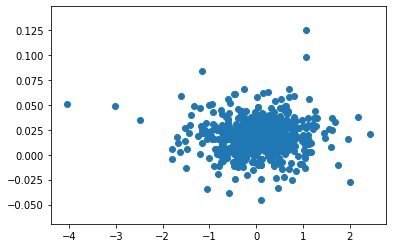

In [16]:
# Compare prediction and actual
arma_y_pred = arma_model.predict(params = arma_model_fitted.params)
y_true = df_train['Price']

plt.scatter(y_true,arma_y_pred)
plt.show()

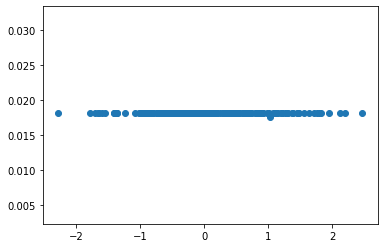

In [17]:
# Compare prediction and actual
arma_y_pred_test = arma_model.predict(params = arma_model_fitted.params,
                                     start = len(df_train),
                                     end = len(df_train)+len(df_test)-1)
y_test = df_test['Price']

plt.scatter(y_test,arma_y_pred_test)
plt.show()

## Random forest

In [18]:
rf_model = RandomForestRegressor(max_depth=5, n_estimators=30, random_state=0)

In [19]:
X_train = df_train.shift(1).iloc[1:,:].values

y_train = df_train['Price'].iloc[1:]

X_test = df_test.shift(1).iloc[1:,:].values

y_test = df_test['Price'].iloc[1:]

In [20]:
# Fit the model
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [21]:
# Predict with the model
rf_y_pred = rf_model.predict(X_test)

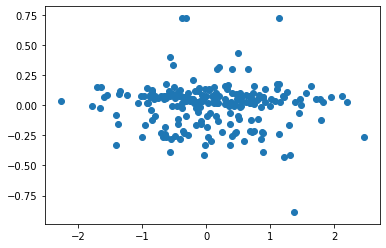

In [22]:
# Compare prediction and actual in the test set
plt.scatter(y_test,rf_y_pred)
plt.show()

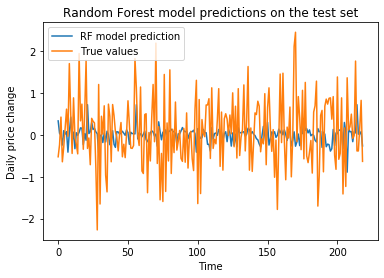

In [25]:
# Compare prediction and actual in the test set
plt.plot(np.asarray(rf_y_pred),label='RF model prediction')
plt.plot(np.asarray(y_test),label='True values')
plt.xlabel('Time')
plt.ylabel('Daily price change')
#plt.yscale('log')
plt.title('Random Forest model predictions on the test set')
plt.legend(loc='upper left')
plt.savefig('../Outputs/daily_pred_rf.pdf')
plt.show()

In [26]:
mean_squared_error(rf_y_pred,y_test)

0.7358365156955068